In [1]:
# import holoviews as hv
# import hvplot.pandas
import panel as pn
import polars as pl
import numpy as np
import jupyter_black

from panel.widgets import Tabulator

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")
jupyter_black.load()

pn.extension("tabulator", template="material", sizing_mode="stretch_width")

Make a gas estimator for gas congestion using a Kalman Filter  

In [2]:
from pykalman import KalmanFilter

In [3]:
df = pl.read_parquet("../data/raw_eth/blocks/*.parquet")
# turn into numpy matrix
df.head(5).select("block_number", "gas_used", "base_fee_per_gas")

block_number,gas_used,base_fee_per_gas
u32,u64,u64
13000000,1282538,46240053122
13000001,30019450,40954251693
13000002,8534883,46070176818
13000003,29989710,43588101124
13000004,2369403,49032876084


In [4]:
SAMPLE_SIZE: int = 7600

In [5]:
np_matrix = (
    df.select("block_number", "gas_used", "base_fee_per_gas")
    .sort(by="block_number")
    .tail(SAMPLE_SIZE)
    .to_numpy()
)

np_matrix[1]

array([   19032401,    10691506, 27197882487], dtype=uint64)

In [6]:
# Extract only 'gas_used' and 'base_fee_per_gas' columns
data = np_matrix[:, 1:]

# Set up the Kalman Filter
kf = KalmanFilter(
    transition_matrices=np.eye(2),  # 2x2 Identity matrix for transition
    observation_matrices=np.eye(2),  # 2x2 Identity matrix for observation
    initial_state_mean=data[0, :],  # Initial state
    initial_state_covariance=np.ones((2, 2)),  # Initial covariance
)

# Now, refine the Kalman Filter parameters using EM algorithm
kf = kf.em(data, n_iter=5)

# Apply the Kalman Filter to your data
(filtered_state_means, filtered_state_covariances) = kf.filter(data)

In [7]:
# Assuming filtered_state_means is your NumPy array from the Kalman Filter
kalman_df = pl.DataFrame(
    {
        "gas_used": filtered_state_means[:, 0],
        "base_fee_per_gas": filtered_state_means[:, 1],
    }
)

kalman_df.head(5)

gas_used,base_fee_per_gas
f64,f64
-29163502.002749864,27242054143.997234
-24193162.412826132,30787995049.612164
-14976251.136995664,30491100697.168053
-6325433.2680203635,30223944057.28139
-1582504.7312938115,29497019811.422676


In [8]:
# Extract the block_number column from np_matrix
block_numbers = np_matrix[:, 0]

# Combine the block_number with the estimated values
combined_data = np.column_stack((block_numbers, filtered_state_means))

# Convert the combined array into a Polars DataFrame
df_combined = pl.DataFrame(
    {
        "block_number": combined_data[:, 0],
        "gas_used_kalman": combined_data[:, 1],
        "base_fee_per_gas_kalman": combined_data[:, 2],
    }
)

In [9]:
df_combined.head(5)

block_number,gas_used_kalman,base_fee_per_gas_kalman
f64,f64,f64
19032400,-29163502.002749864,27242054143.997234
19032401,-24193162.412826132,30787995049.612164
19032402,-14976251.136995664,30491100697.168053
19032403,-6325433.2680203635,30223944057.28139
19032404,-1582504.7312938115,29497019811.422676


In [10]:
kalman_combined = df_combined.with_columns(pl.col("block_number").cast(pl.UInt32)).join(
    df, on="block_number"
)

In [19]:
kalman_combined.shape

(7600, 10)

In [20]:
chart_df = (
    kalman_combined.select(
        "block_number",
        "gas_used_kalman",
        "base_fee_per_gas_kalman",
        "gas_used",
        "base_fee_per_gas",
    )
    .with_columns(
        (pl.col("base_fee_per_gas_kalman") / 10**9),
        (pl.col("base_fee_per_gas") / 10**9),
        pl.col("gas_used_kalman"),
        pl.col("gas_used"),
    )
    .with_columns(
        (pl.col("base_fee_per_gas_kalman") - pl.col("base_fee_per_gas")).alias(
            "base_fee_per_gas_diff"
        ),
    )
)

In [23]:
chart_df.select("base_fee_per_gas_diff").sum()

base_fee_per_gas_diff
f64
18.18558528827954


In [33]:
chart_df.select("base_fee_per_gas_diff").filter(
    pl.col("base_fee_per_gas_diff") > 0
).sum()

base_fee_per_gas_diff
f64
1304.7983556708189


In [35]:
chart_df.select("base_fee_per_gas_diff").filter(
    pl.col("base_fee_per_gas_diff") < 0
).sum()

base_fee_per_gas_diff
f64
-1286.6127703825393


Text(0, 0.5, 'Frequency')

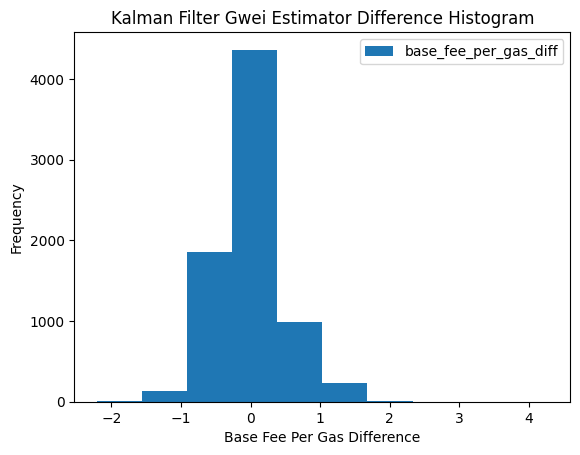

In [32]:
# Generate the histogram
ax = (
    chart_df.select("base_fee_per_gas_diff")
    .to_pandas()
    .plot.hist(bins=10, title="Kalman Filter Gwei Estimator Difference Histogram")
)

# Set the labels and title separately
ax.set_xlabel("Base Fee Per Gas Difference")
ax.set_ylabel("Frequency")

In [12]:
def get_block_volatility(df: pl.LazyFrame, n: int = 1) -> pl.DataFrame:
    return (
        df.collect(streaming=True)
        .sort(by="block_number")
        .with_columns(
            (pl.col("base_fee_per_gas") / 10**9).alias("base_fee_per_gas_gwei"),
        )
        .with_columns(
            pl.col("base_fee_per_gas_gwei")
            .diff(n=n)
            .alias("base_fee_per_gas_gwei_diff"),
            pl.col("gas_used").diff(n=n).alias("gas_used_diff"),
        )
    )

In [13]:
df = pl.scan_parquet("../data/raw_eth/blocks/*.parquet")

In [14]:
minute_vol = get_block_volatility(df, n=300)  # 300 = hourly

In [15]:
# Sample data
data = minute_vol.select("base_fee_per_gas_gwei_diff").fill_null(0).to_numpy()

In [16]:
# Confirm Consistency

M1 = np.mean(data)
M2 = np.var(data)
M3 = stats.skew(data)
M4 = stats.kurtosis(data)

NameError: name 'stats' is not defined

In [ ]:
print(f"Mean: {M1}")
print(f"Variance: {M2}")
print(f"Skewness: {M3}")
print(f"Kurtosis: {M4}")

Mean: -0.009644207664538018
Variance: 4969.463510827945
Skewness: [10.10404207]
Kurtosis: [4733.74321625]


In [ ]:
STOP

In [ ]:
print(f"Mean: {M1}")
print(f"Variance: {M2}")
print(f"Skewness: {M3}")
print(f"Kurtosis: {M4}")

Mean: 43.26456985348126
Variance: 6558.780576862949
Skewness: [48.93205068]
Kurtosis: [3603.6623823]


In [ ]:
# Sample data
data = minute_vol.select("base_fee_per_gas_gwei").to_pandas()

# Normalize the data
normalized_data = stats.zscore(data)

# Calculate kurtosis
kurtosis_value = stats.kurtosis(normalized_data)

print("Kurtosis of the normalized data:", kurtosis_value)

Kurtosis of the normalized data: [3603.6623823]


In [ ]:
minute_vol.select("base_fee_per_gas_gwei").to_pandas().kurtosis()

base_fee_per_gas_gwei    3603.665366
dtype: float64

In [ ]:
minute_vol.select("base_fee_per_gas_gwei").to_pandas().skew()

base_fee_per_gas_gwei    48.932063
dtype: float64

In [ ]:
minute_vol.plot.hist("base_fee_per_gas_gwei_diff", bins=1000, xlim=(-10, 10))

:Histogram   [base_fee_per_gas_gwei_diff]   (base_fee_per_gas_gwei_diff_count)